100%|██████████| 9.91M/9.91M [00:01<00:00, 5.63MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 127kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


Epoch [1/20] Loss: 189.6576
Epoch [2/20] Loss: 167.4279
Epoch [3/20] Loss: 163.1383
Epoch [4/20] Loss: 160.5692
Epoch [5/20] Loss: 158.7714
Epoch [6/20] Loss: 157.4501
Epoch [7/20] Loss: 156.4303
Epoch [8/20] Loss: 155.6198
Epoch [9/20] Loss: 154.8892
Epoch [10/20] Loss: 154.2288
Epoch [11/20] Loss: 153.7133
Epoch [12/20] Loss: 153.1871
Epoch [13/20] Loss: 152.7148
Epoch [14/20] Loss: 152.3344
Epoch [15/20] Loss: 151.9619
Epoch [16/20] Loss: 151.5555
Epoch [17/20] Loss: 151.2799
Epoch [18/20] Loss: 150.9472
Epoch [19/20] Loss: 150.6800
Epoch [20/20] Loss: 150.4139


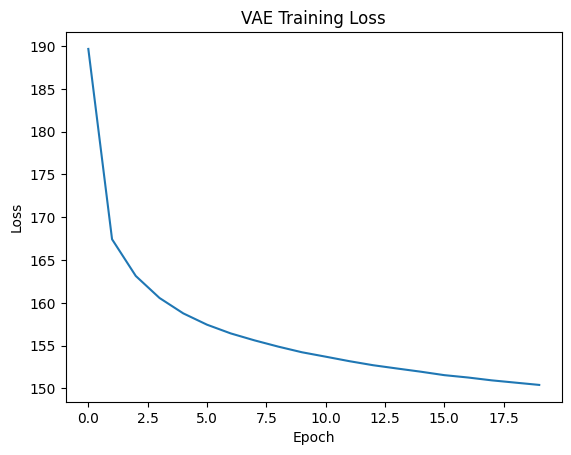

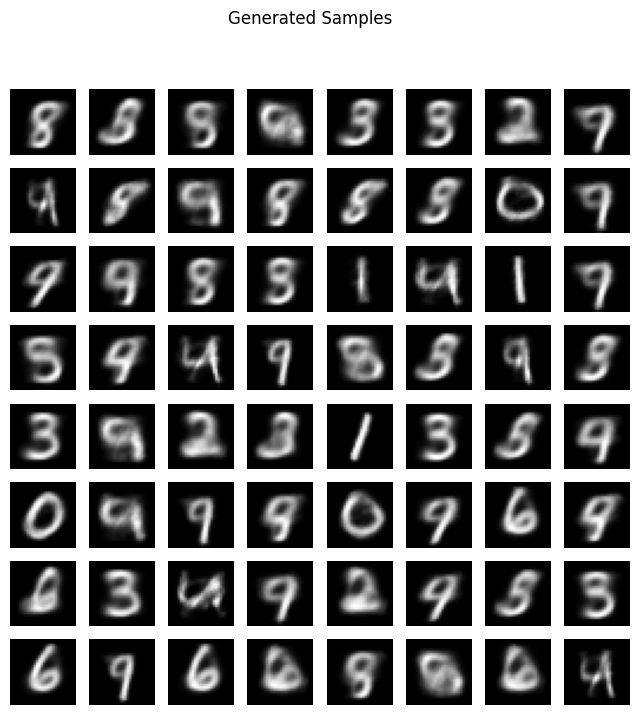

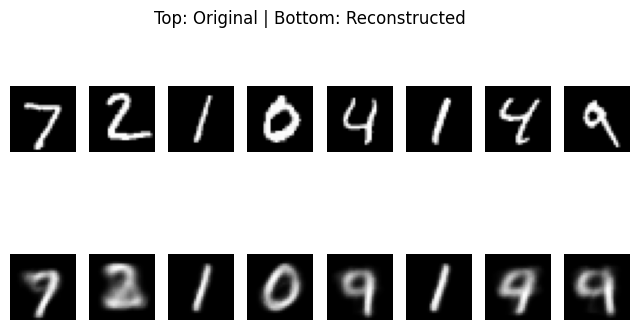

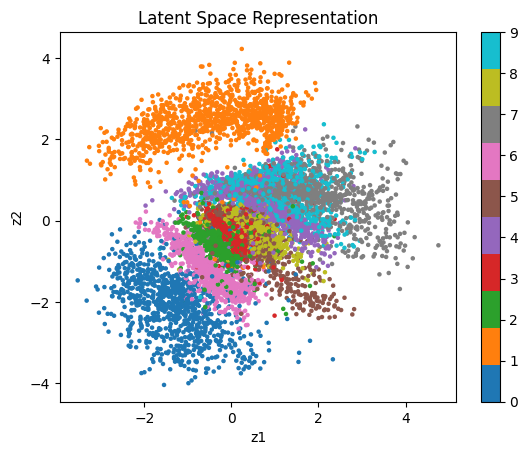

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


batch_size = 128
epochs = 20
latent_dim = 2
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
test_data = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.mu = nn.Linear(400, latent_dim)
        self.logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu()

plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(samples[i].view(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Samples")
plt.show()


with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.view(-1, 28*28).to(device)
    recon, _, _ = model(data)

plt.figure(figsize=(8,4))
for i in range(8):
    # Original
    plt.subplot(2,8,i+1)
    plt.imshow(data[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

    # Reconstruction
    plt.subplot(2,8,i+9)
    plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()


latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 28*28).to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu())
        labels.append(target)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

plt.scatter(latents[:,0], latents[:,1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("Latent Space Representation")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()